# National Tsing Hua University Robust and Stochastic Portfolio Optimization (Fall 2021)

 - Programming HW 5

In [2]:
# Basic
import cvxpy as cp
import numpy as np
import pandas as pd 
import datetime as dt 
import yfinance as yf 
import statsmodels.api as sm

# Self-Built Function
from Utils.Convex_Hull            import portfolio_convex_hull
from Utils.Portfolio_Summary      import Backtest_Summay_DF
from Utils.Portfolio_Optimization import CVX_Markowitz_Optimization,CVX_Shortfall_Risk_Optimization,CVX_Shortfall_Risk_Uncertainty_Optimization

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

# Cheybyshev Approxmiation Bounds for Shortfall Risk

In [3]:
class CVX_Shortfall_Risk_Optimization():
    
    def __init__(self,u,cov,shortfall_risk,chance):

        self.u      = u 
        self.chance = chance
        self.cov    = cov 
        self.params = cp.Variable(cov.shape[1])
        self.shortfall_risk = shortfall_risk

    def constraint_1(self,params):
        
        return  [ cp.sum(params) <= 2 ]  # Allow leverage 
    
    def constraint_2(self,params):

        bound = [ cp.abs(params[i]) <= 2 for i in range(self.cov.shape[1])] # weights Bound Constriants

        return bound 
    
    def constraint_3(self,params):
        
        chance_paramter = np.sqrt(self.chance/(1-self.chance))
        left_norm2      = np.sqrt(self.cov) @ params  * chance_paramter        
        right           = self.u.T @  params  - self.shortfall_risk/252

        return [ cp.SOC(right , left_norm2) ]

    def Optimize(self):

        constraints = []
        constraints += self.constraint_1(self.params) 
        constraints += self.constraint_2(self.params) 
        constraints += self.constraint_3(self.params) 
        
        Objective_Function = self.u @ self.params  - (1/2) * cp.quad_form(self.params ,self.cov) 

        prob  = cp.Problem( cp.Maximize(Objective_Function) , constraints )
        
        return prob , self.params

# Get Security Data

In [4]:
# Portfolio : 10 Assets
start_date = '2019-01-02'
end_date   = '2020-01-02'

# yfinance likes the tickers formatted as a list
tickers   = ["FB","MSFT","AAPL","AMZN","NFLX",'GOOG','TSLA','AMD','JPM','SPY','^DJI','SBUX','SQ','TM','COST']
ticks     = yf.Tickers(tickers)
Stock_DF  = ticks.history(start=start_date, end=end_date).Close
Stock_DF  = Stock_DF.fillna(value=0)
Return_DF = Stock_DF.pct_change()

Stock_DF.head()

[*********************100%***********************]  15 of 15 completed


,AAPL,AMD,AMZN,COST,FB,GOOG,JPM,MSFT,NFLX,SBUX,SPY,SQ,TM,TSLA,^DJI
Date,,,,,,,,,,,,,,,
2019-01-02,38.326290,18.830000,1539.130005,194.445023,135.679993,1045.849976,90.652061,97.782440,267.660004,60.852764,238.694550,57.200001,116.279999,62.023998,23346.240234
2019-01-03,34.508717,17.049999,1500.280029,190.323654,131.740005,1016.059998,89.363739,94.185211,271.200012,58.213158,232.998596,52.419998,114.650002,60.071999,22686.220703
2019-01-04,35.981869,19.000000,1575.390015,195.850494,137.949997,1070.709961,92.658173,98.565681,297.570007,60.143192,240.803055,58.180000,119.730003,63.537998,23433.160156
2019-01-07,35.901772,20.570000,1629.510010,196.572220,138.050003,1068.390015,92.722595,98.691406,315.339996,60.143192,242.701721,60.720001,121.279999,66.991997,23531.349609
2019-01-08,36.586170,20.750000,1656.579956,198.044083,142.529999,1076.280029,92.547752,99.406960,320.269989,60.190502,244.981949,63.119999,122.309998,67.070000,23787.449219


          Equities Covex Hull
----------------------------------------
      Unbiased_Std  Expected_Returns
AAPL      0.016498          0.002671
AMD       0.033971          0.004111
AMZN      0.014382          0.000832
COST      0.010138          0.001531
FB        0.017471          0.001801
GOOG      0.015228          0.001094
JPM       0.011775          0.001543
MSFT      0.012509          0.001909
NFLX      0.021853          0.000994
SBUX      0.012164          0.001393
SPY       0.007897          0.001110
SQ        0.026305          0.000707
TM        0.008519          0.000791
TSLA      0.030817          0.001668
^DJI      0.007850          0.000831
----------------------------------------


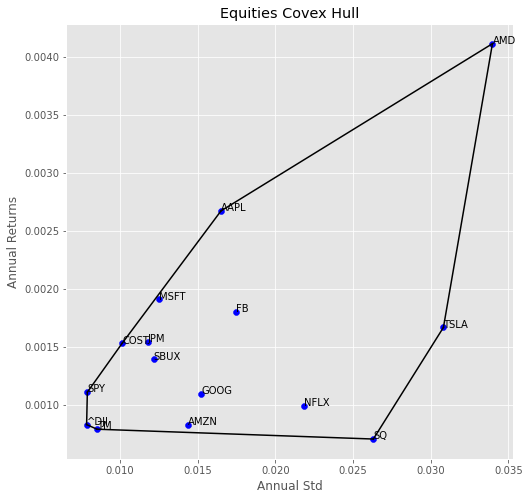

In [5]:
Expected_Return   = Stock_DF.pct_change().mean() 
Unbiased_Std      = Stock_DF.pct_change().std() 

Cov_Matrix = Stock_DF.pct_change().cov()
u          = Expected_Return.values
sigma      = Unbiased_Std.values 


CovexHull_DF = pd.DataFrame({
    "Unbiased_Std" : Unbiased_Std ,
    "Expected_Returns" : Expected_Return ,
    })

portfolio_convex_hull(CovexHull_DF)

# Insample Periods Optimization Result

 - Mean Variance 
 - Shortfall Rsik 

Max F(x) :  0.01592046272072911
Total Weight :  2.000000041081599


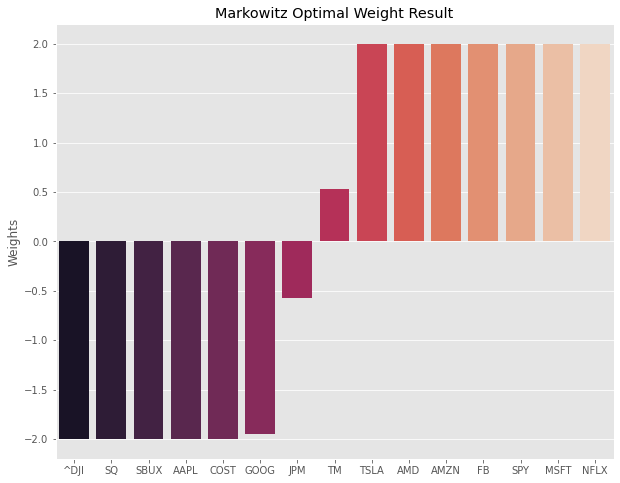

In [6]:
Markowitz_Model                   = CVX_Markowitz_Optimization(u=u,cov=Cov_Matrix.values)
Markowitz_Result,Markowitz_Params = Markowitz_Model.Optimize()

print("Max F(x) : "                       , Markowitz_Result.solve()    )
print("Total Weight : " , np.sum(Markowitz_Params.value) )
Weight_result = pd.DataFrame(Markowitz_Params.value , columns=['Weights'],index=tickers ).sort_values(by='Weights')

# Figure
fig = plt.figure(figsize=(10,8))
ax  = sns.barplot(x=Weight_result.index,y=Weight_result.Weights,palette="rocket").set(title='Markowitz Optimal Weight Result')
plt.show()

Max F(x) :  0.007230529263229451
Total Weight :  -0.38651397195152626


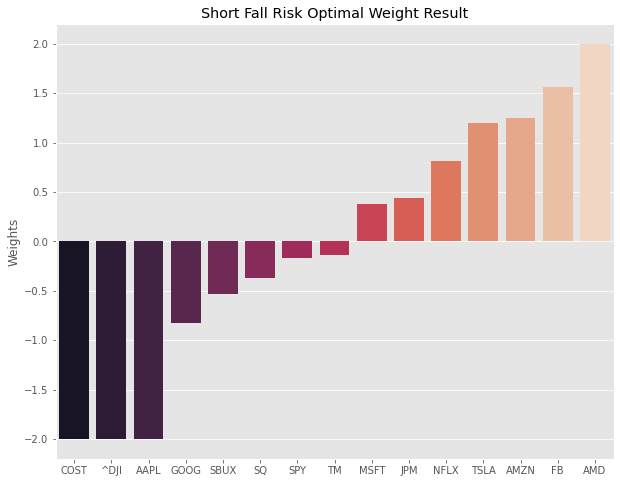

In [7]:
Short_Fall_Risk_Model                         = CVX_Shortfall_Risk_Optimization(u=u ,cov=Cov_Matrix.values,shortfall_risk=0.01,chance=0.5)
Short_Fall_Risk_Result,Short_Fall_Risk_Params = Short_Fall_Risk_Model.Optimize()

print("Max F(x) : "      , Short_Fall_Risk_Result.solve()                     )
print("Total Weight : "  , np.sum(Short_Fall_Risk_Params.value)               )
Weight_result = pd.DataFrame(Short_Fall_Risk_Params.value , columns=['Weights'],index=tickers ).sort_values(by='Weights')

# Figure
fig = plt.figure(figsize=(10,8))
ax  = sns.barplot(x=Weight_result.index,y=Weight_result.Weights,palette="rocket").set(title='Short Fall Risk Optimal Weight Result')
plt.show()

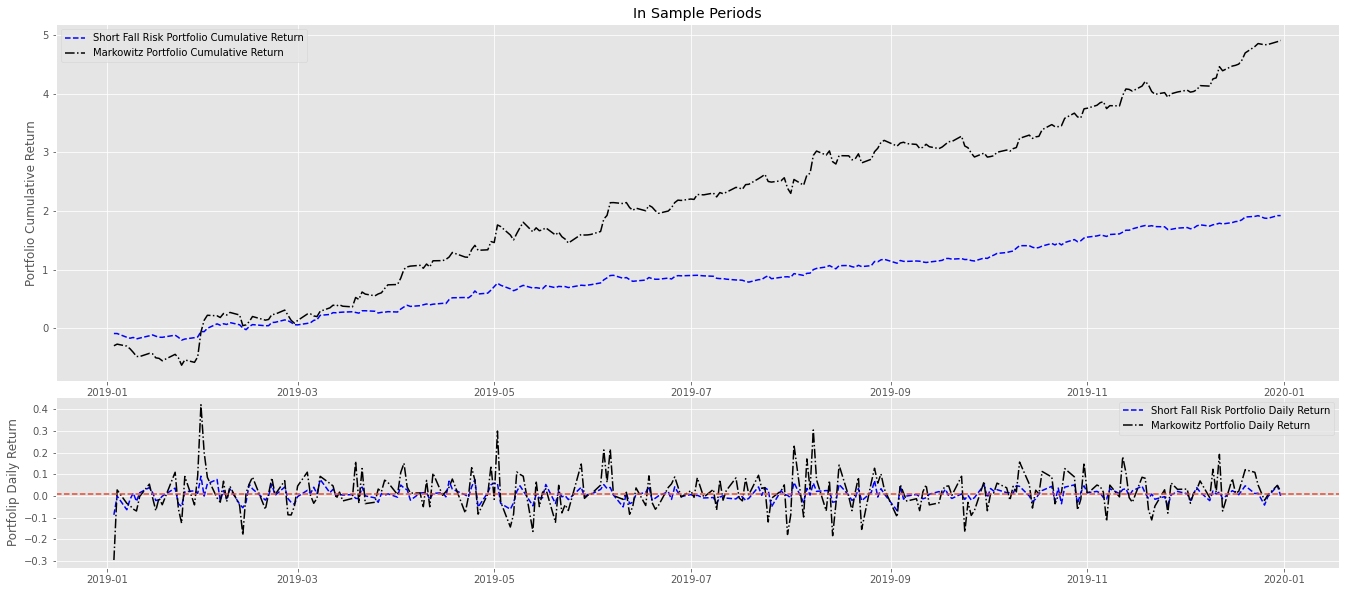

In [8]:
shall_fall_raik_portfolio_return_df = pd.DataFrame(Return_DF.dropna() @ Short_Fall_Risk_Params.value ,columns=['Portfolio Returns'])
Markowitz_portfolio_return_df       = pd.DataFrame(Return_DF.dropna() @ Markowitz_Params.value       ,columns=['Portfolio Returns'])

plt.subplots(figsize=(23,10))
ax1 = plt.subplot2grid((6,1),(0,0),rowspan=4,colspan=1)
ax1.set_title("In Sample Periods")
ax1.plot(shall_fall_raik_portfolio_return_df.index , shall_fall_raik_portfolio_return_df['Portfolio Returns'].cumsum() ,color='blue'  ,label='Short Fall Risk Portfolio Cumulative Return',linestyle='--')
ax1.plot(Markowitz_portfolio_return_df.index       , Markowitz_portfolio_return_df['Portfolio Returns'].cumsum()       ,color='black' ,label='Markowitz Portfolio Cumulative Return',linestyle='-.')
ax1.set_ylabel('Portfolio Cumulative Return')
ax1.legend()

ax2 = plt.subplot2grid((6,1),(4,0),rowspan=3,colspan=1)
ax2.plot(shall_fall_raik_portfolio_return_df.index , shall_fall_raik_portfolio_return_df['Portfolio Returns'] ,color='blue'  ,label='Short Fall Risk Portfolio Daily Return',linestyle='--')
ax2.plot(Markowitz_portfolio_return_df.index       , Markowitz_portfolio_return_df['Portfolio Returns']       ,color='black' ,label='Markowitz Portfolio Daily Return',linestyle='-.')
ax2.set_ylabel('Portfolip Daily Return')
ax2.axhline(0.01 , linestyle='--')
ax2.legend()
plt.show()


In [9]:
Insample_Periods_SFR = Backtest_Summay_DF(start_date=start_date,end_date=end_date,Daily_Returns=shall_fall_raik_portfolio_return_df['Portfolio Returns'].values)
Insample_Periods_MR  = Backtest_Summay_DF(start_date=start_date,end_date=end_date,Daily_Returns= Markowitz_portfolio_return_df['Portfolio Returns'].values)

Insample_Periods_SFR.columns = ['Insample Shortfall Rsik BackTest']
Insample_Periods_MR.columns  = ['Insample Markowitz Portfolio BackTest']

pd.concat([Insample_Periods_SFR,Insample_Periods_MR],axis=1)

,Insample Shortfall Rsik BackTest,Insample Markowitz Portfolio BackTest
Start Date,2019-01-02,2019-01-02
End Date,2020-01-02,2020-01-02
-,-,-
Annual Return,1.929302,4.925826
Annual Volitiliy,0.462128,1.349243
Cumulative Return,1.921646,4.906279
Sharpe Ratio,4.174819,3.650807
Calmar Ratio,15.106292,13.734098
Daily Value at Risk,-0.03824,-0.104187
Maximum Drawdown,0.127715,0.358657


# Out off Sample Periods Result :  Next Months Dataset

In [10]:
start_date = '2020-01-02'
end_date   = '2020-01-31'

# yfinance likes the tickers formatted as a list
ticks     = yf.Tickers(tickers)
Test_Stock_DF  = ticks.history(start=start_date, end=end_date).Close
Test_Stock_DF  = Test_Stock_DF.fillna(value=0)
Test_Return_DF = Test_Stock_DF.pct_change()

[*********************100%***********************]  15 of 15 completed


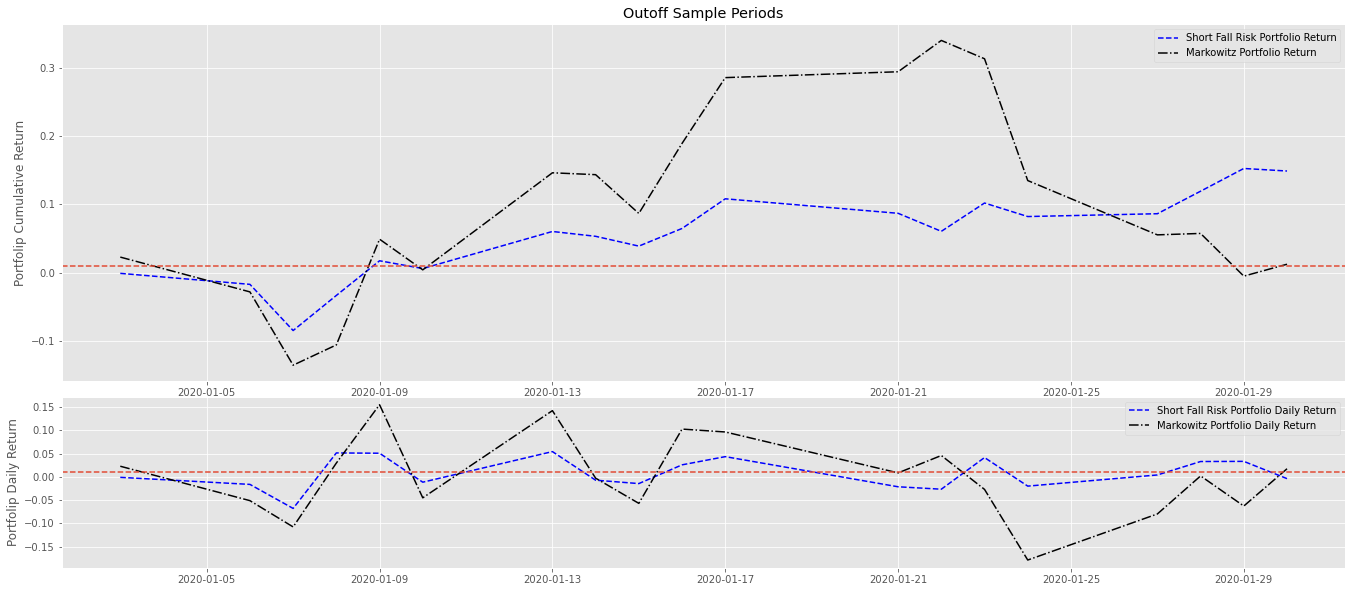

In [11]:
shall_fall_raik_portfolio_return_df  = pd.DataFrame(Test_Return_DF.dropna() @ Short_Fall_Risk_Params.value, columns=['Short Fall Risk Portfolio Returns'])
Markowitz_portfolio_return_df        = pd.DataFrame(Test_Return_DF.dropna() @ Markowitz_Params.value, columns=['Markowitz Portfolio Returns'])


plt.subplots(figsize=(23,10))
ax1 = plt.subplot2grid((6,1),(0,0),rowspan=4,colspan=1)
ax1.set_title("Outoff Sample Periods")
ax1.plot(shall_fall_raik_portfolio_return_df.index  , shall_fall_raik_portfolio_return_df['Short Fall Risk Portfolio Returns'].cumsum()    ,color='blue',label='Short Fall Risk Portfolio Return',linestyle='--' )
ax1.plot(Markowitz_portfolio_return_df.index        , Markowitz_portfolio_return_df ['Markowitz Portfolio Returns'].cumsum()              ,color='black' ,label='Markowitz Portfolio Return'  ,linestyle='-.'       )
ax1.set_ylabel('Portfolip Cumulative Return')
ax1.axhline(0.01 , linestyle='--')
ax1.legend()

ax2 = plt.subplot2grid((6,1),(4,0),rowspan=3,colspan=1)
ax2.plot(shall_fall_raik_portfolio_return_df.index , shall_fall_raik_portfolio_return_df['Short Fall Risk Portfolio Returns'] ,color='blue'  ,label='Short Fall Risk Portfolio Daily Return',linestyle='--')
ax2.plot(Markowitz_portfolio_return_df.index       , Markowitz_portfolio_return_df ['Markowitz Portfolio Returns']            ,color='black' ,label='Markowitz Portfolio Daily Return',linestyle='-.')
ax2.set_ylabel('Portfolip Daily Return')
ax2.axhline(0.01 , linestyle='--')
ax2.legend()
plt.show()

In [12]:
Outoff_sample_Periods_SFR = Backtest_Summay_DF(start_date=start_date,end_date=end_date,Daily_Returns = shall_fall_raik_portfolio_return_df['Short Fall Risk Portfolio Returns'].values)
Outoff_sample_Periods_MR  = Backtest_Summay_DF(start_date=start_date,end_date=end_date,Daily_Returns = Markowitz_portfolio_return_df['Markowitz Portfolio Returns'].values)

Outoff_sample_Periods_SFR .columns = ['Outoff Sample Shortfall Rsik BackTest']
Outoff_sample_Periods_MR.columns   = ['Outoff Sample Markowitz Portfolio BackTest']

pd.concat([Outoff_sample_Periods_SFR,Outoff_sample_Periods_MR],axis=1)

,Outoff Sample Shortfall Rsik BackTest,Outoff Sample Markowitz Portfolio BackTest
Start Date,2020-01-02,2020-01-02
End Date,2020-01-31,2020-01-31
-,-,-
Annual Return,1.975952,0.16457
Annual Volitiliy,0.518636,1.313639
Cumulative Return,0.148981,0.012408
Sharpe Ratio,3.809899,0.125278
Calmar Ratio,23.583406,0.47654
Daily Value at Risk,-0.030552,-0.114494
Maximum Drawdown,0.083786,0.345344


# Robustness and Stochastic Optimization : Answer Not Sure

Max F(x) :  0.007230529338501134
Total Weight :  -0.3865354657901645


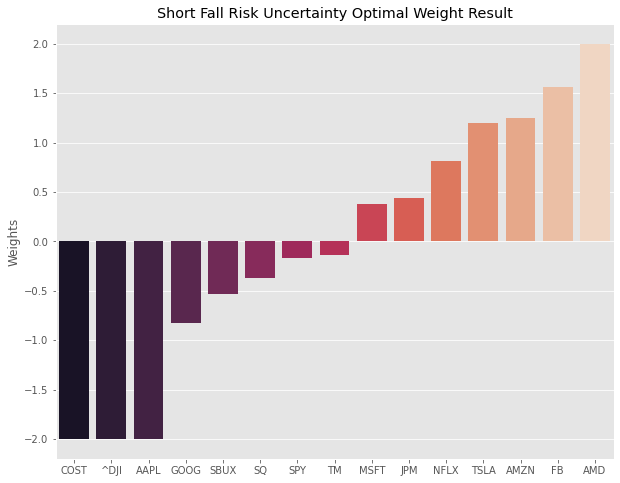

In [104]:
Short_Fall_Risk_Uncertainty_Model                           = CVX_Shortfall_Risk_Uncertainty_Optimization(u=u ,cov=Cov_Matrix.values,shortfall_risk=0.01,chance=0.5)
Short_Fall_Risk_Uncertainty_Result,Short_Fall_Risk_Uncertainty_Params,v = Short_Fall_Risk_Uncertainty_Model.Optimize()

print("Max F(x) : "      , Short_Fall_Risk_Uncertainty_Result.solve()                     )
print("Total Weight : "  , np.sum(Short_Fall_Risk_Uncertainty_Params.value)               )
Weight_result = pd.DataFrame(Short_Fall_Risk_Uncertainty_Params.value , columns=['Weights'],index=tickers ).sort_values(by='Weights')

# Figure
fig = plt.figure(figsize=(10,8))
ax  = sns.barplot(x=Weight_result.index,y=Weight_result.Weights,palette="rocket").set(title='Short Fall Risk Uncertainty Optimal Weight Result')
plt.show()